In [1]:
#2021.07.06. TUE
#Hankyeong

#00. 패키지 호출 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.linalg import toeplitz

#00-1. 시각화 옵션 설정
%matplotlib inline

#00-2. warning message ignore 
warnings.filterwarnings(action='ignore')

#00-3. 씨드넘버 설정
np.random.seed(2021)
tf.random.set_seed(2021)


In [2]:
#07. reuter(로이터) 데이터셋 전처리하기. 
#(1) 데이터셋 불러오기. 
(X_train, y_train), (X_test,y_test) = reuters.load_data(
    num_words=None, test_split=0.2
)

#(2) train, test 데이터셋의 차원 확인하기. 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8982,), (8982,), (2246,), (2246,))

In [3]:
#(3) target 변수의 category값 설정하기. 
category = np.max(y_train) + 1
category

46

In [4]:
#WHY? 1을 더하는 이유는, Python에서 index가 0부터 시작하기 때문임. 

In [5]:
#(4) 첫 sample 출력하기. 
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
#MEMO. keras 데이터셋의 값은 tokenizer(index화)처리한 값으로 반환함. 

In [7]:
#(5) index값과 매칭되는 value 사전정의하기.  
index_dict = {}
for key, value in reuters.get_word_index().items() : 
    index_dict[value] = key

#(6) 총 단어 갯수 확인하기. 
voca_size = len(index_dict)
voca_size

30979

In [8]:
#(6) 첫 sample(기사) 복원하기. 
' '.join([index_dict[s] for s in X_train[0]])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [9]:
#(7) sample의 최대 문장 길이 확인하기. 
max_len = max([len(l) for l in X_train])
max_len

2376

In [10]:
#(8) sample의 평균 문장 길이 확인하기. 
mean_len = sum(map(len,X_train))/len(X_train)
mean_len

145.5398574927633

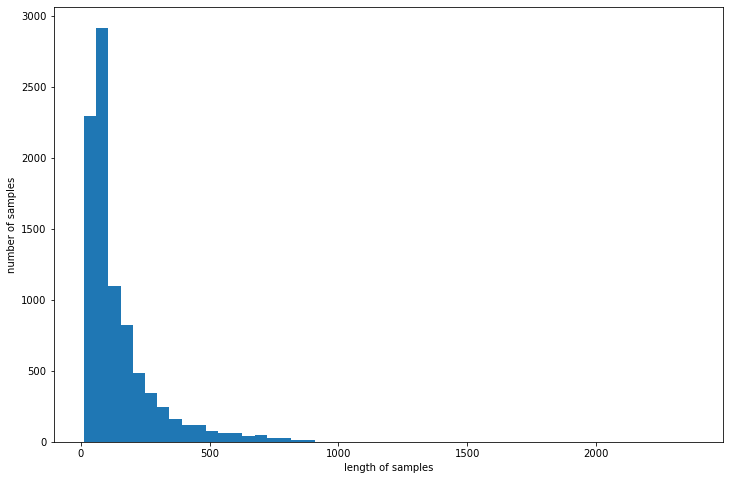

In [11]:
#(9) sample의 문장 구성에 따른 빈도 확인하기. 
plt.figure(figsize=(12,8))
plt.hist([len(l) for l in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

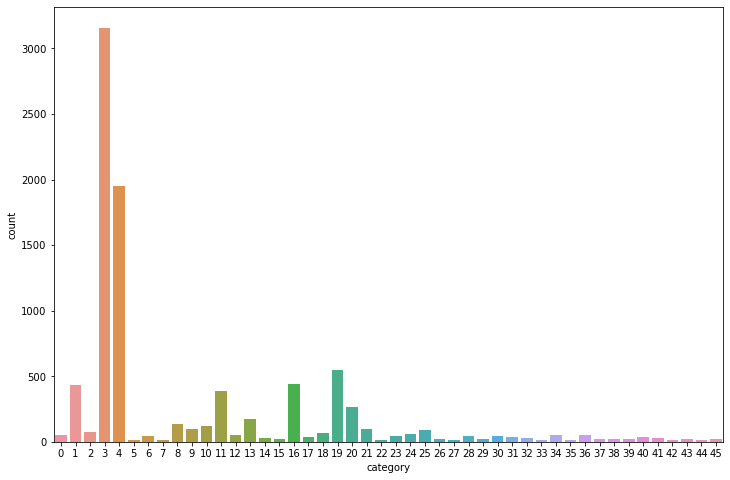

In [12]:
#(10) target 변수의 category 빈도 확인하기. 
plt.figure(figsize=(12,8))
sns.countplot(y_train)
plt.xlabel('category')
plt.show()

In [13]:
#(11) 총 단어 갯수에 맞춰 재분할하기.
INPUT_DIM = 5000
(X_train, y_train), (X_test,y_test) = reuters.load_data(
    num_words=INPUT_DIM, test_split=0.2
)

#(12) 적절한 문장 길이 정의 후 패딩처리하기.  
max_len = 250
X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

#(13) target 변수 원핫인코딩 처리하기.
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

#(14) train, test 데이터셋 차원 확인하기. 
X_train_pad.shape, Y_train.shape, X_test_pad.shape, Y_test.shape

((8982, 250), (8982, 46), (2246, 250), (2246, 46))

In [14]:
#08. LSTM 모델로 로이터 데이터셋 다중 분류하기. 
#(1) 모델 정의하기. 
model = Sequential([
    Embedding(INPUT_DIM, max_len),
    LSTM(128),
    Dense(category, activation='softmax')
])

#(2) 모델의 요약 정보 확인하기. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 250)         1250000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               194048    
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 1,449,982
Trainable params: 1,449,982
Non-trainable params: 0
_________________________________________________________________


In [15]:
#(3) 모델의 컴파일 설정하기.  
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy')

#(4) checkpointer 객체 설정하기. 
MODEL_PATH = '../../model/reuters_best_LSTM_model.h5'
checkpointer = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

#(5) ealrystopping 객체 설정하기. 
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=25
)

#(6) 모델 학습하기. 
model_fit = model.fit(
    X_train_pad, Y_train,
    validation_split=0.2,
    epochs=2500,
    batch_size=100,
    callbacks=[checkpointer, earlystopping],
    verbose=0
)

#(7) best 모델 할당하기. 
best_model = load_model(MODEL_PATH)

#(8) best 모델로 예측 및 평가하기.
best_model.evaluate(X_test_pad,Y_test)

71/71 [==============================] - 1s 8ms/step - loss: 1.4261 - accuracy: 0.6612


[1.4260939359664917, 0.6611754298210144]

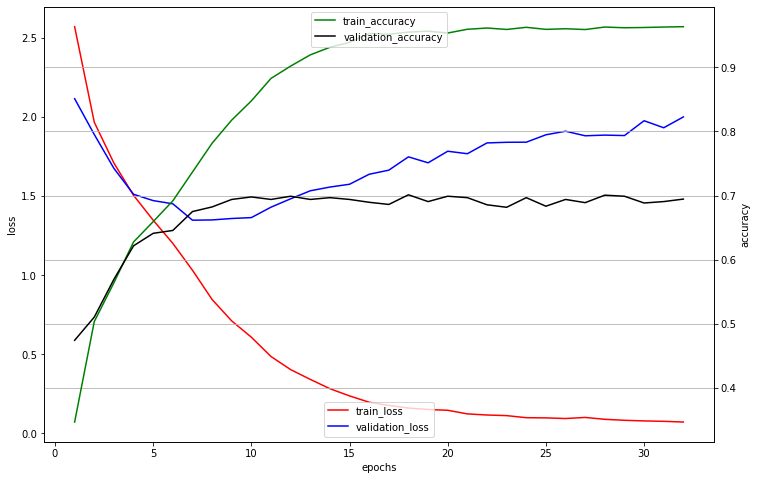

In [16]:
#(9) 훈련 과정 시각화하기. 
y_acc = model_fit.history['accuracy']
y_val_acc = model_fit.history['val_accuracy']

y_loss = model_fit.history['loss']
y_val_loss = model_fit.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.set_xlabel('epochs')

ax0.plot(x_len, y_loss, c='red', label='train_loss')
ax0.plot(x_len, y_val_loss, c='blue', label='validation_loss')
ax0.set_ylabel('loss')
ax0.legend(loc='lower center')

ax1.plot(x_len, y_acc, c='green', label='train_accuracy')
ax1.plot(x_len, y_val_acc, c='k', label='validation_accuracy')
ax1.set_ylabel('accuracy')
ax1.legend(loc='upper center')

plt.grid()
plt.show()